In [393]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

df = pd.read_csv('/Users/balmukundmishra/Desktop/2025-Learning/ML-Course/9_Problem_Statements/data/common.csv')
find_train_df = df

    

# Drop Unnamed index column
df = df.drop(columns=['Unnamed: 0'])

# Convert 'isleak' to integer
df['isleak'] = df['isleak'].astype(int)

# Convert 'time' to datetime (just time, not date)
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S', errors='coerce')

# Map day names to numbers
day_map = {'Mon': 0, 'Tue': 1, 'Wed': 2, 'Thu': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6}
df['day_num'] = df['day'].map(day_map)

# Extract hour and minute as float
df['hour'] = df['time'].dt.hour + df['time'].dt.minute / 60.0

# Cyclical encoding of hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Cyclical encoding of day
df['day_sin'] = np.sin(2 * np.pi * df['day_num'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_num'] / 7)

df['flow_x_duration'] = df['flow_rate'] * df['duration']
df['flow_div_variability'] = df['flow_rate'] / (df['variability'] + 1e-5)  # Avoid divide-by-zero

# Compute mean leak rate per hour
hourly_leak_rate = df.groupby('hour')['isleak'].mean()
df['leak_rate_hour'] = df['hour'].map(hourly_leak_rate)



df['is_night'] = df['hour'].between(0, 6).astype(int)
df['is_peak_hour'] = df['hour'].between(6, 9) | df['hour'].between(17, 21)
df['is_weekend'] = df['day_num'].isin([5, 6]).astype(int)

# Leak likelihood per day
leak_rate_day = df.groupby('day_num')['isleak'].mean()
df['leak_rate_day'] = df['day_num'].map(leak_rate_day)

df['flow_per_second'] = df['flow_rate'] / (df['duration'] + 1e-5)
df['variability_per_sec'] = df['variability'] / (df['duration'] + 1e-5)

df['flow_bin'] = pd.qcut(df['flow_rate'], q=5, labels=False)
df['duration_bin'] = pd.cut(df['duration'], bins=[0, 30, 60, 120, np.inf], labels=False)

df['flow_x_variability'] = df['flow_rate'] * df['variability']
df['duration_x_variability'] = df['duration'] * df['variability']

df['prev_flow'] = df['flow_rate'].shift(1)
df['flow_diff'] = df['flow_rate'] - df['prev_flow']
df['prev_duration'] = df['duration'].shift(1)

df['z_flow_hour'] = df.groupby('hour')['flow_rate'].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
df['z_duration_day'] = df.groupby('day_num')['duration'].transform(lambda x: (x - x.mean()) / x.std(ddof=0))

df['variability_bin'] = pd.qcut(df['variability'], q=4, labels=False)

leak_prob_flow_bin = df.groupby('flow_bin')['isleak'].mean()
df['leak_prob_flow_bin'] = df['flow_bin'].map(leak_prob_flow_bin)

# Drop raw time/day columns
df_model = df.drop(columns=['time', 'day'])

# Separate features and target
X = df_model.drop(columns=['isleak'])
y = df_model['isleak']

# Drop raw time/day columns
df_model = df.drop(columns=['time', 'day'])

# Separate features and target
X = df_model.drop(columns=['isleak'])
y = df_model['isleak']

# print("Final features:\n", X.columns.tolist())
print("Target distribution:\n", y.value_counts(normalize=True))

if not isinstance(X, pd.DataFrame):
    X_train_scaled = pd.DataFrame(X)

# Drop columns that contain only zeros
non_zero_cols = X.columns[(X != 0).any()]
X_train_filtered = X[non_zero_cols]

X_train_filtered = X_train_filtered.dropna(axis=1)


# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_train_filtered, y, stratify=y, test_size=0.3, random_state=42
)

# Identify numeric columns for scaling
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = []

numeric_transformer = StandardScaler()
one_hencoder = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

smote = SMOTE(k_neighbors=3,random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Confirm balancing
print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts().to_dict())

# Train the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred = rf.predict(X_test_scaled)

# Evaluate
#print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
#print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

importances = rf.feature_importances_
feature_names = X.columns
# Plot top 20
sorted_idx = np.argsort(importances)[-10:]
top_features = []
for i in sorted_idx:
    top_features.append(feature_names[i])

print("Top 10 features are : \n",top_features)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.to_numpy(), dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)


Target distribution:
 isleak
0    0.9886
1    0.0114
Name: proportion, dtype: float64
Before SMOTE: {0: 6920, 1: 80}
After SMOTE: {0: 6920, 1: 6920}
Top 10 features are : 
 ['variability', 'flow_per_second', 'prev_flow', 'leak_rate_day', 'flow_x_duration', 'flow_bin', 'duration_x_variability', 'duration', 'flow_x_variability', 'leak_rate_hour']


In [394]:
import torch.nn as nn

class DeepLeakDetectorNN(nn.Module):
    def __init__(self, input_dim):
        super(DeepLeakDetectorNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [397]:
X_train_resampled.shape

(13840, 24)

In [395]:
import torch.nn as nn
import torch.optim as optim

model = LeakDetectorNN(input_dim=X_train_resampled.shape[1])
criterion = nn.BCELoss()  # Binary classification

# L2 via weight_decay, L1 handled separately
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
l1_lambda = 1e-5

def l1_penalty(model):
    return sum(param.abs().sum() for param in model.parameters())

# Training loop skeleton
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss += l1_lambda * l1_penalty(model)  # Add L1
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 5 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [0/200], Loss: 0.6907
Epoch [5/200], Loss: 0.6571
Epoch [10/200], Loss: 0.6231
Epoch [15/200], Loss: 0.5866
Epoch [20/200], Loss: 0.5448
Epoch [25/200], Loss: 0.4997
Epoch [30/200], Loss: 0.4517
Epoch [35/200], Loss: 0.4015
Epoch [40/200], Loss: 0.3547
Epoch [45/200], Loss: 0.3047
Epoch [50/200], Loss: 0.2616
Epoch [55/200], Loss: 0.2251
Epoch [60/200], Loss: 0.1915
Epoch [65/200], Loss: 0.1692
Epoch [70/200], Loss: 0.1490
Epoch [75/200], Loss: 0.1333
Epoch [80/200], Loss: 0.1262
Epoch [85/200], Loss: 0.1186
Epoch [90/200], Loss: 0.1116
Epoch [95/200], Loss: 0.1043
Epoch [100/200], Loss: 0.1015
Epoch [105/200], Loss: 0.0990
Epoch [110/200], Loss: 0.0955
Epoch [115/200], Loss: 0.0943
Epoch [120/200], Loss: 0.0887
Epoch [125/200], Loss: 0.0889
Epoch [130/200], Loss: 0.0866
Epoch [135/200], Loss: 0.0847
Epoch [140/200], Loss: 0.0826
Epoch [145/200], Loss: 0.0814
Epoch [150/200], Loss: 0.0821
Epoch [155/200], Loss: 0.0773
Epoch [160/200], Loss: 0.0769
Epoch [165/200], Loss: 0.0739
Ep

In [396]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor).numpy()
    y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9986    0.9734    0.9858      2966
           1     0.2752    0.8824    0.4196        34

    accuracy                         0.9723      3000
   macro avg     0.6369    0.9279    0.7027      3000
weighted avg     0.9904    0.9723    0.9794      3000



In [398]:
def preprocess_new_data(df):
    df = df.drop(columns=['Unnamed: 0'], errors='ignore')
    df['isleak'] = df['isleak'].astype(int)
    df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S', errors='coerce')

    # Map day
    day_map = {'Mon': 0, 'Tue': 1, 'Wed': 2, 'Thu': 3, 'Fri': 4, 'Sat': 5, 'Sun': 6}
    df['day_num'] = df['day'].map(day_map)
    df['hour'] = df['time'].dt.hour + df['time'].dt.minute / 60.0

    # Cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_num'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_num'] / 7)

    # Engineered features
    df['flow_x_duration'] = df['flow_rate'] * df['duration']
    df['flow_div_variability'] = df['flow_rate'] / (df['variability'] + 1e-5)
    df['leak_rate_hour'] = df.groupby('hour')['isleak'].transform('mean')
    df['is_night'] = df['hour'].between(0, 6).astype(int)
    df['is_peak_hour'] = df['hour'].between(6, 9) | df['hour'].between(17, 21)
    df['is_weekend'] = df['day_num'].isin([5, 6]).astype(int)
    df['leak_rate_day'] = df.groupby('day_num')['isleak'].transform('mean')
    df['flow_per_second'] = df['flow_rate'] / (df['duration'] + 1e-5)
    df['variability_per_sec'] = df['variability'] / (df['duration'] + 1e-5)
    df['flow_bin'] = pd.qcut(df['flow_rate'], q=5, labels=False, duplicates='drop')
    df['duration_bin'] = pd.cut(df['duration'], bins=[0, 30, 60, 120, np.inf], labels=False)
    df['flow_x_variability'] = df['flow_rate'] * df['variability']
    df['duration_x_variability'] = df['duration'] * df['variability']
    df['prev_flow'] = df['flow_rate'].shift(1)
    df['flow_diff'] = df['flow_rate'] - df['prev_flow']
    df['prev_duration'] = df['duration'].shift(1)
    df['z_flow_hour'] = df.groupby('hour')['flow_rate'].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
    df['z_duration_day'] = df.groupby('day_num')['duration'].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
    df['variability_bin'] = pd.qcut(df['variability'], q=4, labels=False, duplicates='drop')
    df['leak_prob_flow_bin'] = df.groupby('flow_bin')['isleak'].transform('mean')

    df = df.drop(columns=['time', 'day'], errors='ignore')

    # Ensure same features
    # df = df[training_columns.intersection(df.columns)]
    # df = df.dropna(axis=1)

    return df


In [405]:
def prepare_scaled_tensor(df_features, df_labels, preprocessor):
    X_scaled = preprocessor.transform(df_features)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(df_labels.to_numpy(), dtype=torch.float32).view(-1, 1)
    return X_tensor, y_tensor


In [406]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, X_tensor, y_tensor, threshold=0.5):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_tensor)
        y_class = (y_pred >= threshold).int()

    cm = confusion_matrix(y_tensor.numpy(), y_class.numpy())
    report = classification_report(y_tensor.numpy(), y_class.numpy(), zero_division=0)
    
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", report)
    
    return cm, report


In [407]:
# Load your new CSV
new_data = pd.read_csv('/Users/balmukundmishra/Desktop/2025-Learning/ML-Course/9_Problem_Statements/data/rare.csv')

# Match features from training set
# training_columns = pd.Index(X_train_filtered.columns)
# print(training_columns)

# Preprocess
new_data_clean = preprocess_new_data(new_data)

# Separate features and labels
X_new = new_data_clean
y_new = new_data['isleak']

# Scale and convert
X_new_tensor, y_new_tensor = prepare_scaled_tensor(X_new, y_new, preprocessor)

# Evaluate
evaluate_model(model, X_new_tensor, y_new_tensor)




Confusion Matrix:
 [[49997     0]
 [    3     0]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     49997
         1.0       0.00      0.00      0.00         3

    accuracy                           1.00     50000
   macro avg       0.50      0.50      0.50     50000
weighted avg       1.00      1.00      1.00     50000



(array([[49997,     0],
        [    3,     0]]),
 '              precision    recall  f1-score   support\n\n         0.0       1.00      1.00      1.00     49997\n         1.0       0.00      0.00      0.00         3\n\n    accuracy                           1.00     50000\n   macro avg       0.50      0.50      0.50     50000\nweighted avg       1.00      1.00      1.00     50000\n')

In [286]:
class LeakDetectorNN(nn.Module):
    def __init__(self, input_dim):
        super(LeakDetectorNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

model = LeakDetectorNN(input_dim=X_train.shape[1])


In [322]:
import torch.nn as nn

class DeepLeakDetectorNN(nn.Module):
    def __init__(self, input_dim):
        super(DeepLeakDetectorNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [323]:
# Class imbalance handling
pos_weight = torch.tensor([(len(y_train) - sum(y_train)) / sum(y_train)], dtype=torch.float32)

criterion = nn.BCELoss()  # You can also try nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [324]:
EPOCHS = 500
BATCH_SIZE = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f}")


Epoch 5/500 - Loss: 13.0010
Epoch 10/500 - Loss: 11.8405
Epoch 15/500 - Loss: 10.8457
Epoch 20/500 - Loss: 10.4766
Epoch 25/500 - Loss: 9.8619
Epoch 30/500 - Loss: 9.5191
Epoch 35/500 - Loss: 9.0963
Epoch 40/500 - Loss: 8.5136
Epoch 45/500 - Loss: 7.9401
Epoch 50/500 - Loss: 7.7958
Epoch 55/500 - Loss: 7.7190
Epoch 60/500 - Loss: 7.6580
Epoch 65/500 - Loss: 7.5328
Epoch 70/500 - Loss: 7.1143
Epoch 75/500 - Loss: 6.8616
Epoch 80/500 - Loss: 6.8878
Epoch 85/500 - Loss: 6.3612
Epoch 90/500 - Loss: 6.9428
Epoch 95/500 - Loss: 6.2470
Epoch 100/500 - Loss: 6.4531
Epoch 105/500 - Loss: 5.9752
Epoch 110/500 - Loss: 5.8612
Epoch 115/500 - Loss: 5.6850
Epoch 120/500 - Loss: 6.0949
Epoch 125/500 - Loss: 5.5080
Epoch 130/500 - Loss: 5.3879
Epoch 135/500 - Loss: 5.4881
Epoch 140/500 - Loss: 5.0311
Epoch 145/500 - Loss: 5.3730
Epoch 150/500 - Loss: 5.5610
Epoch 155/500 - Loss: 5.7226
Epoch 160/500 - Loss: 5.2153
Epoch 165/500 - Loss: 5.3583
Epoch 170/500 - Loss: 5.2676
Epoch 175/500 - Loss: 5.2484
E

In [325]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor).numpy()
    y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9946    0.9879    0.9912      2966
           1     0.3333    0.5294    0.4091        34

    accuracy                         0.9827      3000
   macro avg     0.6640    0.7586    0.7001      3000
weighted avg     0.9871    0.9827    0.9846      3000



In [326]:
import torch.nn as nn
import torch.optim as optim

model = LeakDetectorNN(input_dim=X_train.shape[1])
criterion = nn.BCELoss()  # Binary classification

# L2 via weight_decay, L1 handled separately
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
l1_lambda = 1e-5

def l1_penalty(model):
    return sum(param.abs().sum() for param in model.parameters())

# Training loop skeleton
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss += l1_lambda * l1_penalty(model)  # Add L1
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 5 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [0/500], Loss: 0.7145
Epoch [5/500], Loss: 0.6721
Epoch [10/500], Loss: 0.6321
Epoch [15/500], Loss: 0.5910
Epoch [20/500], Loss: 0.5472
Epoch [25/500], Loss: 0.5019
Epoch [30/500], Loss: 0.4554
Epoch [35/500], Loss: 0.4131
Epoch [40/500], Loss: 0.3707
Epoch [45/500], Loss: 0.3301
Epoch [50/500], Loss: 0.2946
Epoch [55/500], Loss: 0.2618
Epoch [60/500], Loss: 0.2330
Epoch [65/500], Loss: 0.2101
Epoch [70/500], Loss: 0.1905
Epoch [75/500], Loss: 0.1764
Epoch [80/500], Loss: 0.1636
Epoch [85/500], Loss: 0.1524
Epoch [90/500], Loss: 0.1427
Epoch [95/500], Loss: 0.1387
Epoch [100/500], Loss: 0.1342
Epoch [105/500], Loss: 0.1274
Epoch [110/500], Loss: 0.1248
Epoch [115/500], Loss: 0.1193
Epoch [120/500], Loss: 0.1187
Epoch [125/500], Loss: 0.1156
Epoch [130/500], Loss: 0.1153
Epoch [135/500], Loss: 0.1120
Epoch [140/500], Loss: 0.1097
Epoch [145/500], Loss: 0.1105
Epoch [150/500], Loss: 0.1078
Epoch [155/500], Loss: 0.1048
Epoch [160/500], Loss: 0.1055
Epoch [165/500], Loss: 0.1035
Ep

In [327]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor).numpy()
    y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9986    0.9690    0.9836      2966
           1     0.2459    0.8824    0.3846        34

    accuracy                         0.9680      3000
   macro avg     0.6223    0.9257    0.6841      3000
weighted avg     0.9901    0.9680    0.9768      3000



In [292]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define your model
model = LeakDetectorNN(input_dim=X_train.shape[1])

# Define Binary Cross-Entropy Loss
criterion = nn.BCELoss()

# Use Adam optimizer with L2 regularization via weight_decay
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # L2 here

# Training loop
num_epochs = 5000

for epoch in range(num_epochs):
    model.train()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [0/5000], Loss: 0.6938
Epoch [5/5000], Loss: 0.6562
Epoch [10/5000], Loss: 0.6203
Epoch [15/5000], Loss: 0.5836
Epoch [20/5000], Loss: 0.5448
Epoch [25/5000], Loss: 0.5043
Epoch [30/5000], Loss: 0.4631
Epoch [35/5000], Loss: 0.4205
Epoch [40/5000], Loss: 0.3779
Epoch [45/5000], Loss: 0.3387
Epoch [50/5000], Loss: 0.3010
Epoch [55/5000], Loss: 0.2698
Epoch [60/5000], Loss: 0.2383
Epoch [65/5000], Loss: 0.2139
Epoch [70/5000], Loss: 0.1935
Epoch [75/5000], Loss: 0.1768
Epoch [80/5000], Loss: 0.1671
Epoch [85/5000], Loss: 0.1568
Epoch [90/5000], Loss: 0.1484
Epoch [95/5000], Loss: 0.1426
Epoch [100/5000], Loss: 0.1336
Epoch [105/5000], Loss: 0.1280
Epoch [110/5000], Loss: 0.1268
Epoch [115/5000], Loss: 0.1242
Epoch [120/5000], Loss: 0.1177
Epoch [125/5000], Loss: 0.1184
Epoch [130/5000], Loss: 0.1113
Epoch [135/5000], Loss: 0.1098
Epoch [140/5000], Loss: 0.1101
Epoch [145/5000], Loss: 0.1081
Epoch [150/5000], Loss: 0.1070
Epoch [155/5000], Loss: 0.1026
Epoch [160/5000], Loss: 0.1030

In [293]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor).numpy()
    y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9952    0.9831    0.9891      2966
           1     0.2857    0.5882    0.3846        34

    accuracy                         0.9787      3000
   macro avg     0.6405    0.7857    0.6869      3000
weighted avg     0.9872    0.9787    0.9823      3000



In [294]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define your model
model = LeakDetectorNN(input_dim=X_train.shape[1])

# Binary Cross-Entropy Loss
criterion = nn.BCELoss()

# L2 via weight_decay in optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # L2 regularization

# L1 coefficient
l1_lambda = 1e-5

# Function to compute L1 penalty manually
def l1_penalty(model):
    return sum(param.abs().sum() for param in model.parameters() if param.requires_grad)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    model.train()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Add L1 penalty manually
    loss += l1_lambda * l1_penalty(model)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 5 == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.6f}")


Epoch [1/500] - Loss: 0.710830
Epoch [6/500] - Loss: 0.674187
Epoch [11/500] - Loss: 0.640868
Epoch [16/500] - Loss: 0.604034
Epoch [21/500] - Loss: 0.563603
Epoch [26/500] - Loss: 0.518046
Epoch [31/500] - Loss: 0.470098
Epoch [36/500] - Loss: 0.422560
Epoch [41/500] - Loss: 0.376595
Epoch [46/500] - Loss: 0.333224
Epoch [51/500] - Loss: 0.290604
Epoch [56/500] - Loss: 0.256889
Epoch [61/500] - Loss: 0.228127
Epoch [66/500] - Loss: 0.202274
Epoch [71/500] - Loss: 0.186103
Epoch [76/500] - Loss: 0.168609
Epoch [81/500] - Loss: 0.159195
Epoch [86/500] - Loss: 0.149065
Epoch [91/500] - Loss: 0.144634
Epoch [96/500] - Loss: 0.139100
Epoch [101/500] - Loss: 0.132388
Epoch [106/500] - Loss: 0.129578
Epoch [111/500] - Loss: 0.125378
Epoch [116/500] - Loss: 0.122409
Epoch [121/500] - Loss: 0.122344
Epoch [126/500] - Loss: 0.118543
Epoch [131/500] - Loss: 0.116150
Epoch [136/500] - Loss: 0.114750
Epoch [141/500] - Loss: 0.110475
Epoch [146/500] - Loss: 0.112243
Epoch [151/500] - Loss: 0.109754

In [295]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor).numpy()
    y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9983    0.9666    0.9822      2966
           1     0.2266    0.8529    0.3580        34

    accuracy                         0.9653      3000
   macro avg     0.6124    0.9098    0.6701      3000
weighted avg     0.9895    0.9653    0.9751      3000



In [296]:
num_neg = (y_train == 0).sum()
num_pos = (y_train == 1).sum()

ratio = num_neg / num_pos
print(f"Imbalance ratio (scale_pos_weight): {ratio:.2f}")

Imbalance ratio (scale_pos_weight): 86.50


In [299]:
# scale_pos_weight = (number of negatives) / (number of positives)

# from xgboost import XGBClassifier

# scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')
# xgb.fit(X_train_resampled, y_train_resampled)

# y_pred_xgb = xgb.predict(X_test_scaled)
# print(confusion_matrix(y_test, y_pred_xgb))
# print(classification_report(y_test, y_pred_xgb, zero_division=0))


<Axes: xlabel='isleak', ylabel='leak_rate_hour'>

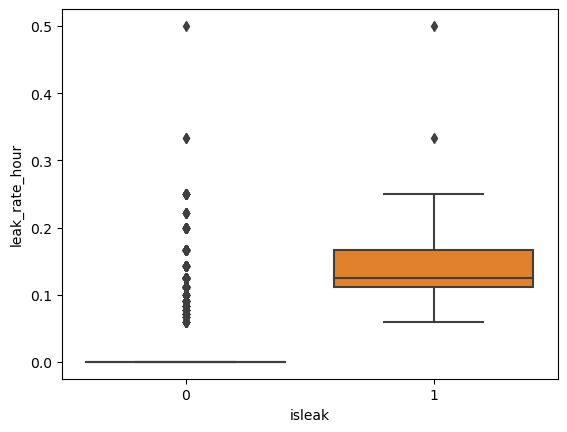

In [ ]:
import seaborn as sns
sns.boxplot(data=df, x='isleak', y='leak_rate_hour')

<Axes: xlabel='isleak', ylabel='flow_div_variability'>

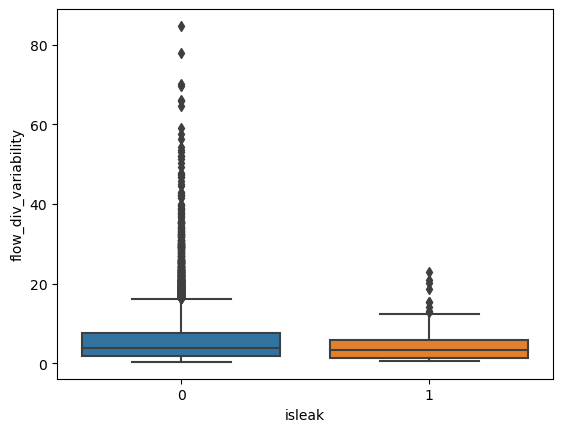

In [ ]:
import seaborn as sns
sns.boxplot(data=df, x='isleak', y='flow_div_variability')

<Axes: xlabel='isleak', ylabel='flow_x_duration'>

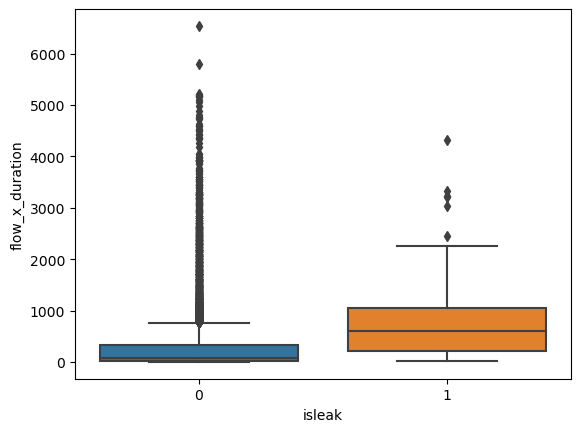

In [ ]:
import seaborn as sns
sns.boxplot(data=df, x='isleak', y='flow_x_duration')

<Axes: xlabel='isleak', ylabel='hour_cos'>

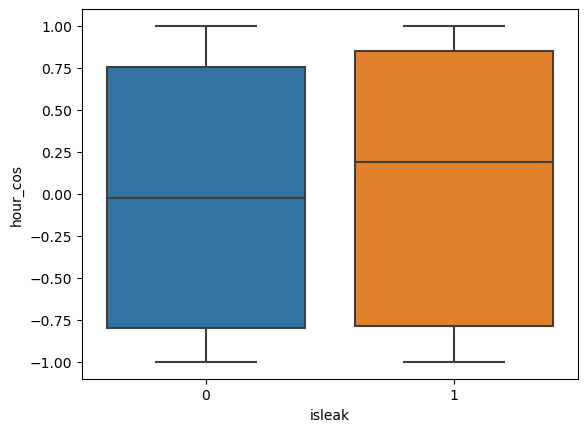

In [ ]:
import seaborn as sns
sns.boxplot(data=df, x='isleak', y='hour_cos')

<Axes: xlabel='isleak', ylabel='day_sin'>

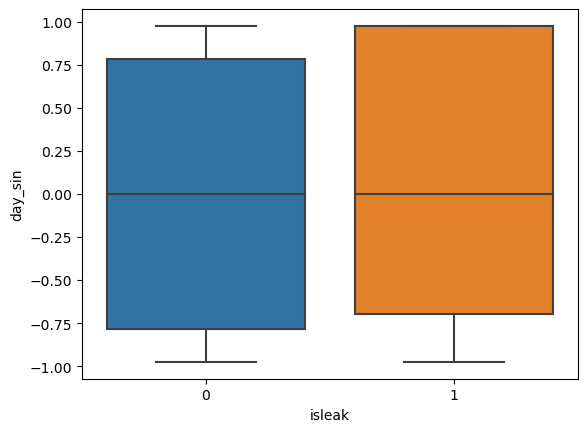

In [ ]:
import seaborn as sns
sns.boxplot(data=df, x='isleak', y='day_sin')

<Axes: xlabel='isleak', ylabel='day_cos'>

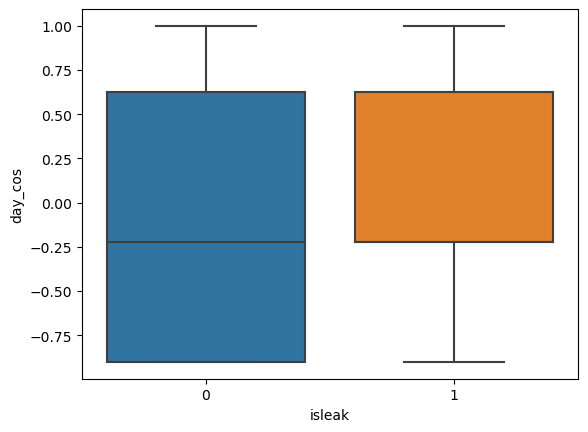

In [ ]:
import seaborn as sns
sns.boxplot(data=df, x='isleak', y='day_cos')

<Axes: xlabel='isleak', ylabel='hour_sin'>

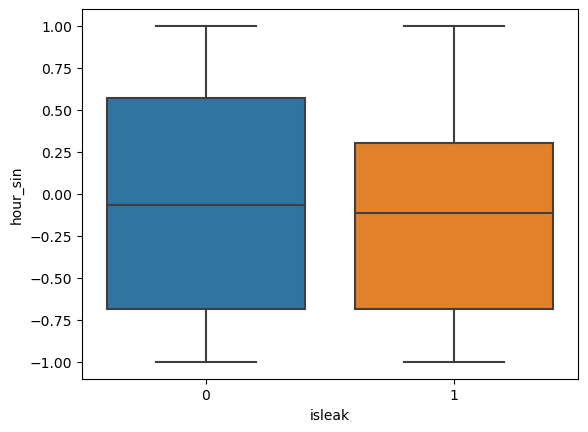

In [ ]:
import seaborn as sns
sns.boxplot(data=df, x='isleak', y='hour_sin')

<Axes: xlabel='isleak', ylabel='hour'>

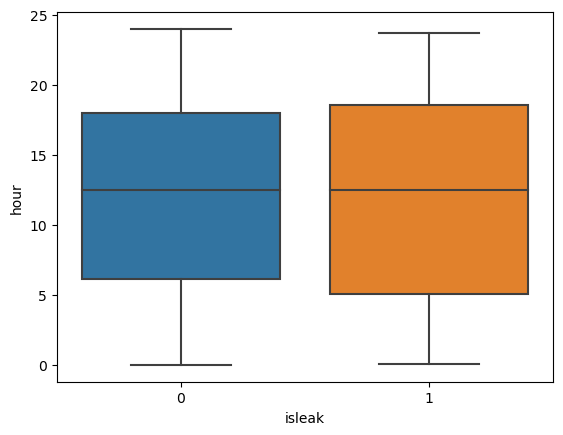

In [ ]:
import seaborn as sns
sns.boxplot(data=df, x='isleak', y='hour')

<Axes: xlabel='isleak', ylabel='day_num'>

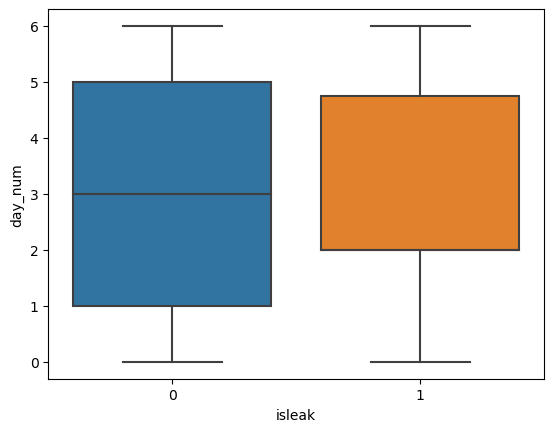

In [ ]:
import seaborn as sns
sns.boxplot(data=df, x='isleak', y='day_num')

<Axes: xlabel='isleak', ylabel='variability'>

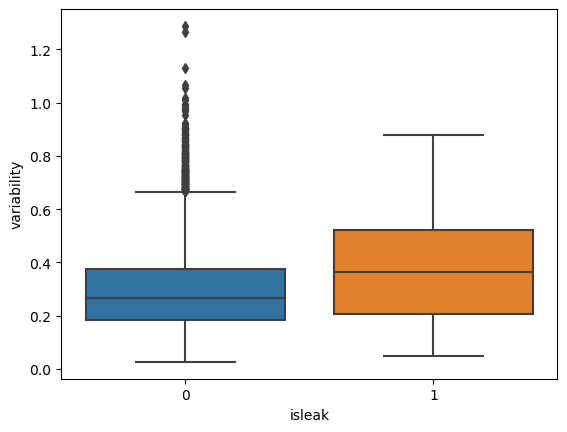

In [ ]:
import seaborn as sns
sns.boxplot(data=df, x='isleak', y='variability')

<Axes: xlabel='isleak', ylabel='duration'>

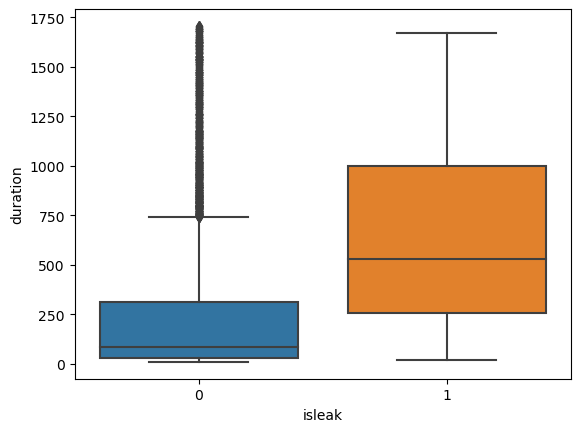

In [ ]:
import seaborn as sns
sns.boxplot(data=df, x='isleak', y='duration')